In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows
from scipy.fft import fft
from scipy.optimize import minimize
from scipy import signal
import pandas as pd

In [2]:
# %% Load the data of each year, remove string date columns & string label first row. 
# Then concatonate to one clean .txt datafile for analysis, with a total of 26304hrs = 26304 datapoints, as 2008 was a leap year 

data7 = pd.read_csv('IDO71009_2007-1.csv', header = None)
data8 = pd.read_csv('IDO71009_2008-1.csv', header = None)
data9 = pd.read_csv('IDO71009_2009-1.csv', header = None)

data7 = data7.iloc[1:,1:]
data7.reset_index(drop=True,inplace=True)
data7.columns = range(data7.shape[1])

data8 = data8.iloc[1:,1:]
data8.reset_index(drop=True,inplace=True)
data8.columns = range(data8.shape[1])

data9 = data9.iloc[1:,1:]
data9.reset_index(drop=True,inplace=True)
data9.columns = range(data9.shape[1])

data = pd.concat([data7,data8,data9], ignore_index=True)

# save data as txt file, cleaned up & reload txt into np.array
data.to_csv('cleaned_data.txt', index=False, sep='\t', header=False)
data = np.loadtxt('cleaned_data.txt')

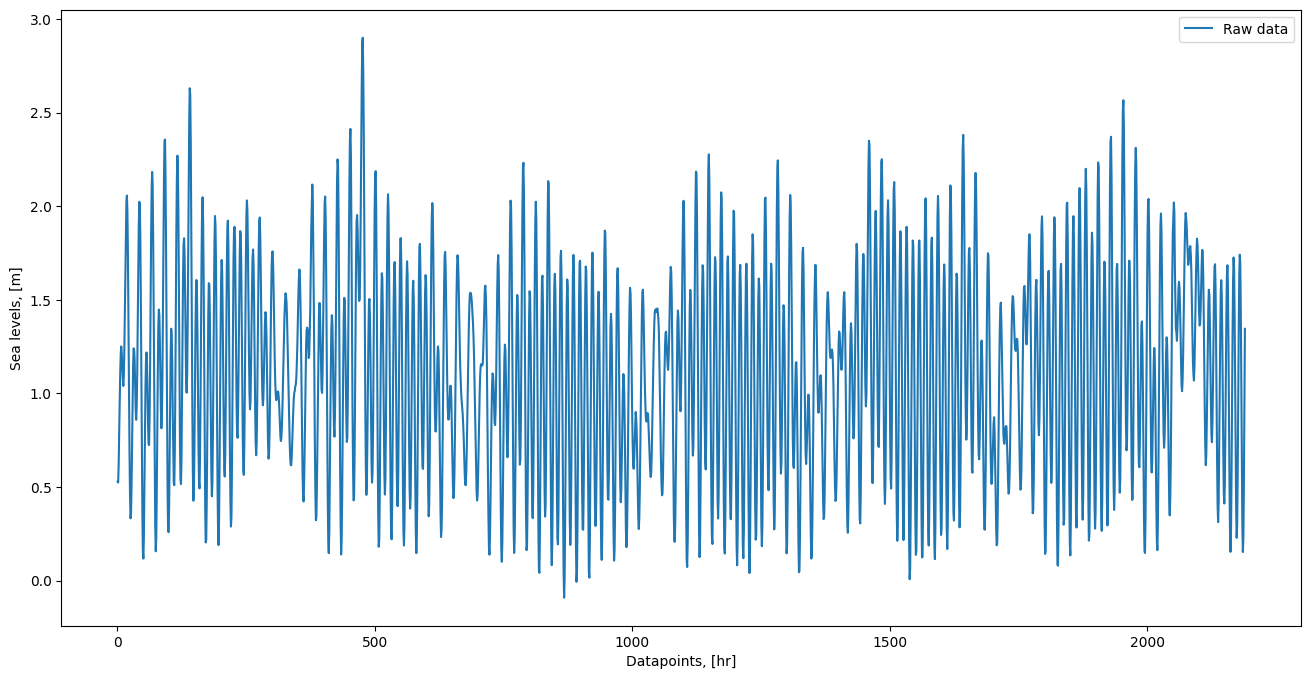

(array([ 140,  141,  474,  475,  476,  477, 1952, 1953]),)


In [3]:
# %% with new cleaned_data, obtain data & display raw to have an understanding of behaviour

y = data[:, 0]  # sea levels

N = 2**14
y = y[:N]
x = np.arange(1, N + 1)

# # Plot the data, w/ & w/o windows
# points = N
# plt.figure(1, figsize=(16,8))
# plt.plot(x[:points], y[:points], label = 'Raw data')
# plt.xlabel('Datapoints, [hr]')
# plt.ylabel('Sea levels, [m]')
# plt.legend()
# plt.title('Total dataset, 2007 - 2009')


# # Zoom in further
# points = 8760   # 8760 hours in 2007
# plt.figure(2, figsize=(16,8))
# plt.plot(x[:points], y[:points], label = 'Raw data')
# plt.xlabel('Datapoints, [hr]')
# plt.ylabel('Sea levels, [m]')
# plt.legend()
# plt.title('2007 data')

# Zoom in further
points = 730*3    # 730 hours in January 2007
plt.figure(3, figsize=(16,8))
plt.plot(x[:points], y[:points], label = 'Raw data')
plt.xlabel('Datapoints, [hr]')
plt.ylabel('Sea levels, [m]')
plt.legend()
plt.show()

peaks = np.where(y[:points] > 2.5)
print(peaks)

[1.07828776e-05 1.16136339e-05 1.16305881e-05 2.23795573e-05
 2.31594510e-05 2.31764052e-05 2.32272678e-05]


/tmp/ipykernel_34867/1423677831.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


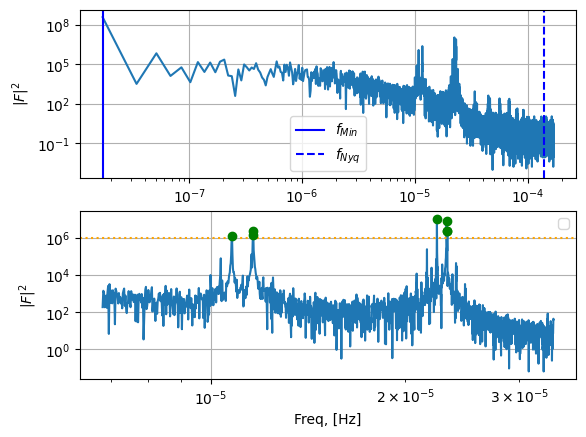

In [4]:
# Sampling, minimum & Nyquist frequency. All must be in seconds

f_s = 1/(60**2)     # sampling frequency = inverse time interval of data obtained, i.e. every hour
f_M = 1/2*f_s
f_m = f_s/N

# FFT and Power Spectral Density (PSD)
P = np.abs(fft(y))**2     # PSD of wave heights
freq = np.arange(1, N + 1) * f_s / N    # frequency axis, in seconds

# Plot the FFT results
l = 0
points = 10000
plt.subplot(211)

plt.loglog(freq[l:points], P[l:points])
plt.axvline(f_m, color='b', linestyle='-', label='$f_{Min}$')
plt.axvline(f_M, color='b', linestyle='--', label='$f_{Nyq}$')
plt.legend()
plt.xlabel('Freq, [Hz]')
plt.ylabel('$|F|^2$')
plt.grid()

l = 400
points = 2000
plt.subplot(212)
plt.loglog(freq[l:points], P[l:points])
plt.axhline(1e6, ls = ':', color = 'orange')
plt.legend()
plt.xlabel('Freq, [Hz]')
plt.ylabel('$|F|^2$')
plt.grid()

# fix the new points of interest to use scatters for maximas
freq = freq[l:points]
P = P[l:points]
peak_index = np.where(P > 1e6)  # since the peaks of interest all go above this value
plt.scatter(freq[peak_index], P[peak_index], color='green', label="Maximums", zorder=5)
print(freq[peak_index])

In [5]:
# convert the frequencies to periods of days

days = (1/freq[peak_index])/(60**2*24)
print(freq[peak_index])
print()
print('Corrolated days from Frequency Characteristic Peaks:')
print(days)
print()
print('approximately 730 hours in a month:')
print(days[0:3]*(730/24))
print()
print('percentage error of FFT day frequency from expected 730 hours a month:')
print( abs((730/24) - days[1:3]*30)/(730/24)*100 )
print()
print('percentage error of FFT lunar day frequency from expected 29.53059 Synodal cycle:')
print( abs(29.53059 - (730*24)/days[0])/29.53059*100 )

[1.07828776e-05 1.16136339e-05 1.16305881e-05 2.23795573e-05
 2.31594510e-05 2.31764052e-05 2.32272678e-05]

Corrolated days from Frequency Characteristic Peaks:
[1.07337526 0.99659367 0.99514091 0.51717172 0.49975598 0.49939039
 0.49829684]

approximately 730 hours in a month:
[32.64849755 30.31305758 30.26886945]

percentage error of FFT day frequency from expected 730 hours a month:
[1.70582942 1.84911538]

percentage error of FFT lunar day frequency from expected 29.53059 Synodal cycle:
55172.66387159891


In [26]:
# now do Wavelet Analysis, first the setup of variables, functions & filters
from scipy import signal
import scipy.fft as sci

N = 2**14
decimate = 2**2 # number of points to sample

y = data[0:N, 0]  # sea levels
y = signal.decimate(y, decimate) # truncate to 2ˆ14/4

N = np.size(y) # no of data points
n = np.linspace(0,N,N) # data point array

f_s = 1/(60**2) # sampling freq
f_s = f_s / decimate # new sampling freq
dt = 1/f_s # new sampling interval
f = n*f_s /N # set frequency axis

P_b = np.abs(sci.fft(y))**2 # power spectrum of y
F_y = sci.fft(y) # fft of y

# Wavelet Transform
t = np.linspace(1,N,N)
t0 = N/2 # location of the wavelet
x = np.arange(0.5, 2.5, 0.1)
scale = 10**x # array of logarithmically spaced scales

scalesize = np.size(scale)

# Mexican Hat
T_mex = (dt*2*np.pi*scale)/np.sqrt(2.5) # array of Fourier wavelenths for Mexican Hat
f_mex = 1/ T_mex # array of frequencies

# Morlet
omega0 = 6.0
T_mor = dt*4.0*np.pi*scale/(omega0 + np.sqrt(2+omega0**2))  # array of Fourier wavelengths for Morlet
f_mor = 1/ T_mor    # array of frequencies

In [27]:
# Generate normally distributed white noise with same SD as data
sigma = np.std(y) #SD of y

ran = sigma**2*np.random.randn(N) # random noise array of length y
F_ran = sci.fft(ran) #FFT of random noise

# Initialise wavelet transform matricies
WT_mex = np.zeros((scalesize ,N)) # mexican hat
WT_mor = np.zeros((scalesize ,N),dtype=complex) # morelet
WTnoi_mex = np.zeros((scalesize ,N)) # mexican hat white noise
WTnoi_mor = np.zeros((scalesize ,N),dtype=complex) # morlet white noise

# Calculating the wavelet transforms
for ii in range(0,scalesize):

    s = scale[ii]
    
    # Mexican hat
    w_mex = ( 1 - ( (t-t0)/s )**2 )*np.exp( -0.5*( (t-t0)/s )**2 )
    w_mex = w_mex*(2/np.sqrt(3))*(1/np.sqrt(np.sqrt(np.pi)))
    w_mex = np.concatenate(( w_mex[N//2:N], w_mex [0:N//2]))                # center and reverse
    F_mex = np.real( np.sqrt( 2*np.pi*s*f_s )*sci.fft(w_mex ))              #FFT of mexican hat function
    WT_mex[ii,:] = np.abs(sci.ifft(np.conjugate(F_mex.T)*F_y ))             #WT of mexican hat with data
    WTnoi_mex[ii,:] = np.abs(sci.ifft(np.conjugate(F_mex)*F_ran ))          #WT of mexican hat with noise
    
    # Morlet
    w_mor = np.exp(1j*omega0*((t-t0)/s))
    w_mor = w_mor*np.exp(-0.5*((t-t0)/s)**2)
    w_mor = w_mor /(np.pi**(0.25))
    w_mor = np.concatenate(( w_mor[int(N/2):N],w_mor [0:int(N/2)]))         # center & reverse
    F_mor = np.sqrt(2*np.pi*s*f_s)*sci.fft(w_mor)                           #FFT of morlet function
    WT_mor[ii,:] = sci.ifft(np.conjugate(F_mor.T)*F_y )                     #WT of morlet with data
    WTnoi_mor[ii,:] = sci.ifft(np.conjugate(F_mor)*F_ran)                   #WT of morlet with noise

# PSD of data & noise
white_noise_power_spectrum = np.abs(sci.fft(ran/(sigma**2)))**2
original_data_power_spectrum = np.abs(sci.fft(y))**2
white_noise_power_spectrum_scaled = np.abs(F_ran)**2

# only values of |WT| > |WT_noise|, find significance via the ratio of these two
def filter(WT,WTnoise,alpha):
    np.random.seed(6)   # for reproduceable results of randomisations
    WT_filter = WT
    for ii in range(0,scalesize):
        for jj in range(0,N-1):
            if np.abs(WT[ii,jj]) < alpha*np.abs(WTnoise[ii,jj]):
                WT_filter[ii,jj] = 0    
    return WT_filter


/tmp/ipykernel_34867/1959533025.py:13: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,0.8e6])


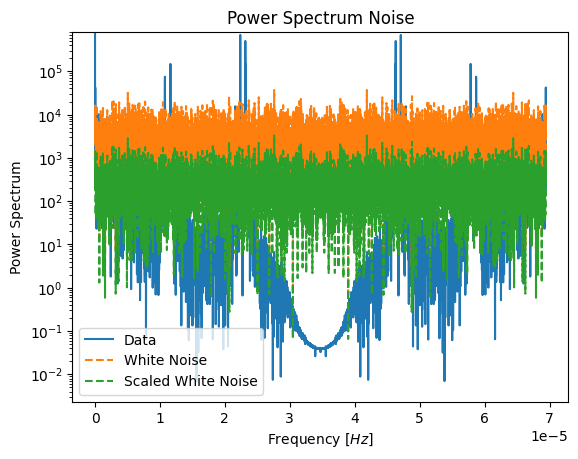

In [28]:
# plot the power spectrum of the noise
# what does this show? Have subplot in loglog space to show the data is the same as before
# perhaps have a plot where the random noise is not scaled accordingly and its effects. 

# FFT noise & data
plt.figure(1)
plt.plot(f, original_data_power_spectrum , label='Data')
plt.semilogy(f, white_noise_power_spectrum , linestyle = '--', label='White Noise')
plt.plot(f, white_noise_power_spectrum_scaled , linestyle = '--', label='Scaled White Noise')
plt.xlabel('Frequency [$Hz$]')
plt.ylabel('Power Spectrum')
plt.legend()
plt.ylim([0,0.8e6])
plt.title('Power Spectrum Noise')
plt.show()


Text(0, 0.5, 'Frequency [$Hz$]')

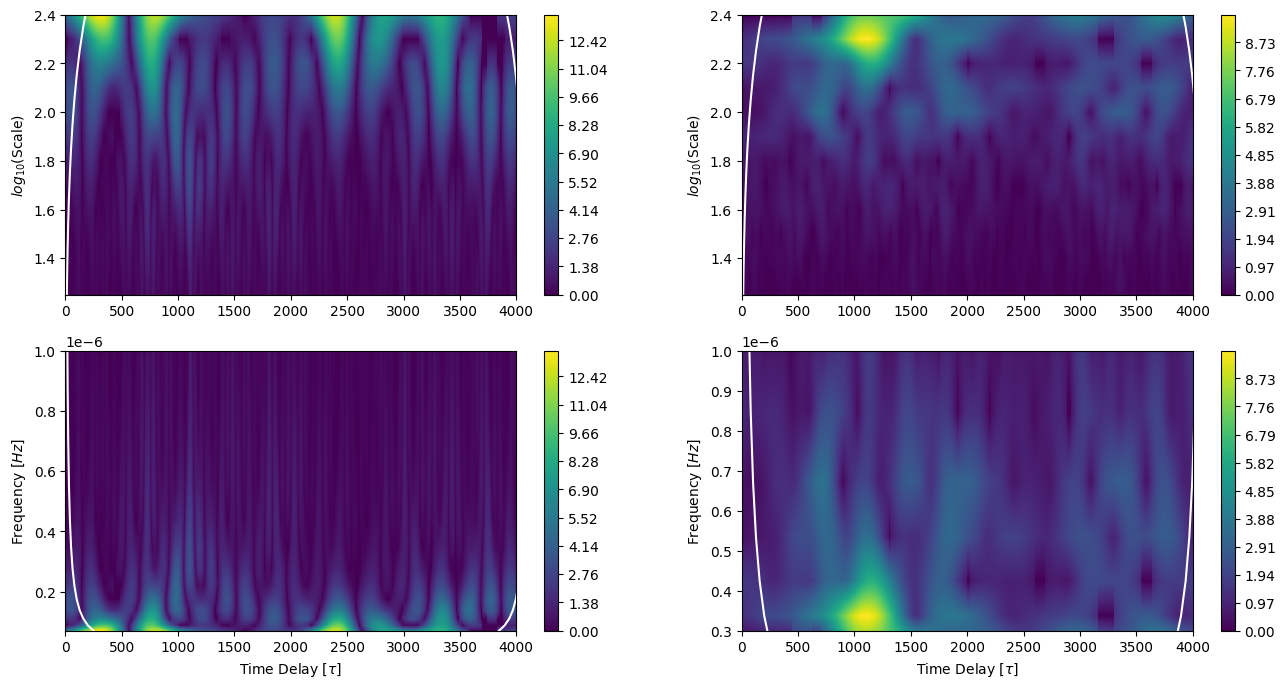

In [29]:
##Plot functions filtered from noise, regards to time delay and scale
alpha = 0.6   # to change the strength of standard deviation
WT_filtered_mex = filter(WT_mex,WTnoi_mex,alpha)
WT_filtered_mor = filter(WT_mor,WTnoi_mor,alpha)

fig = plt.figure(6, figsize=(16,8))
coi = np.sqrt(2.0)*scale

# Plot the functions filtered from noise, regards to time delay and wavelet frequencies
# Plot functions filtered from noise, regards to time delay and scale
res = 1000

# Mex-hat
ax = fig.add_subplot(221)
CB = ax.contourf(t,x,np.abs(WT_filtered_mex), res)
fig.colorbar(CB,ax=ax)
plt.plot(scale ,np.log10(coi),'w-')             # cone of interest boundaries
plt.plot(np.max(t)-scale ,np.log10(coi),'w-')   # cone of interest boundaries
plt.ylim([1.25,2.4])
plt.xlim([0,4000])
plt.ylabel('$log_{10}$(Scale)')
#plt.title('Mex-Hat, Filtered')

# Morlet
ax = fig.add_subplot(222)
CB = ax.contourf(t,x,np.abs(WT_filtered_mor), res)
fig.colorbar(CB,ax=ax)
plt.plot(scale ,np.log10(coi),'w-')
plt.plot(np.max(t)-scale ,np.log10(coi),'w-')
plt.ylim([1.25,2.4])
plt.xlim([0,4000])
plt.ylabel('$log_{10}$(Scale)')
#plt.title('Morlet, Filtered')


# Plot the functions filtered from noise, regards to time delay and wavelet frequencies

## Significances, y-axis = frequencies of the wavelets
# Mex-hat
ax = fig.add_subplot(223)
CB = ax.contourf(t,f_mex,np.abs(WT_filtered_mex), res)
fig.colorbar(CB,ax=ax)
plt.plot(scale ,f_mex,'w-')
plt.plot(np.max(t)-scale ,f_mex,'w-')
plt.plot(scale ,np.log10(coi),'w-')        # removed initially to find the images, values much larger than picture
plt.ylim([0.07e-6,1e-6])
plt.xlim([0,4000])
plt.ylabel('Frequency [$Hz$]')
plt.xlabel('Time Delay [$\\tau$]')
#plt.title('$|W| > |W_{noise}|$, Mex-Hat')

# Morlet
ax = fig.add_subplot(224)
CB = ax.contourf(t,f_mor,np.abs(WT_filtered_mor), res)
fig.colorbar(CB,ax=ax)
plt.plot(scale ,f_mor,'w-')                # removed initially to find the images, values much larger than picture
plt.plot(np.max(t)-scale ,f_mor,'w-')      # removed initially to find the images, values much larger than picture
plt.plot(scale ,np.log10(coi),'w-')        # removed initially to find the images, values much larger than picture
plt.ylim([0.3e-6,1e-6])
plt.xlim([0,4000])
plt.xlabel('Time Delay [$\\tau$]')
plt.ylabel('Frequency [$Hz$]')
#plt.title('$|W| > |W_{noise}|$, Morlet')

